1


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


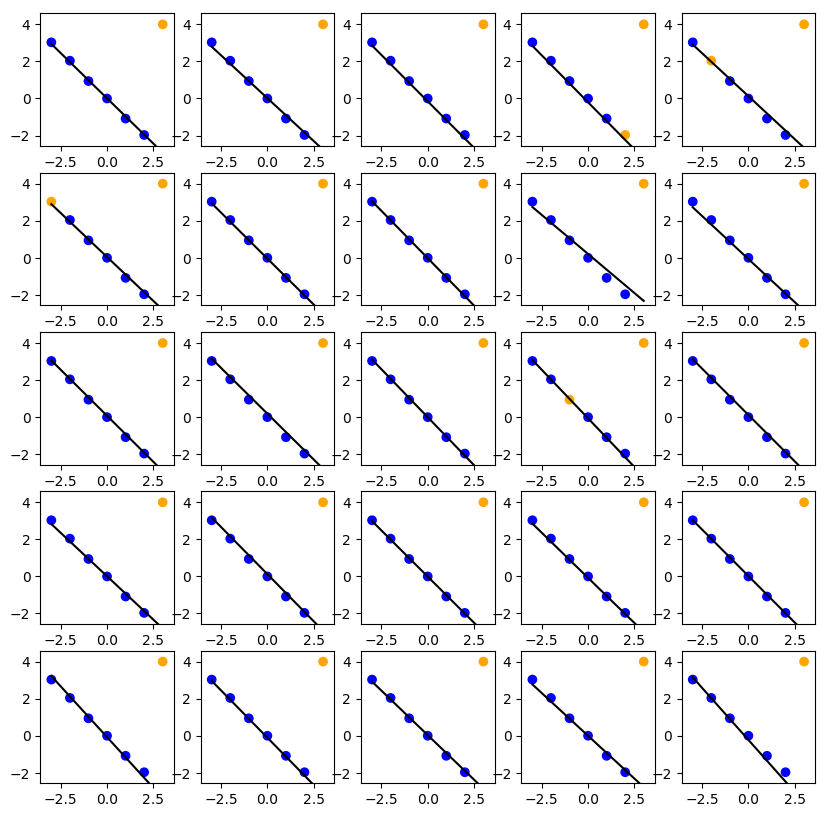

25


In [131]:
using Gen
import Distributions
using PyPlot
using StatsBase

# The probabilistic model
function linear_regression(T::Trace, xs::Array{Float64,1})
    prior_mu = 0.0
    prior_std = 2.0
    outlier_noise = 10.0
    prob_outlier = 0.1
    inlier_noise = 0.2
    slope = normal(prior_mu, prior_std) ~ "slope"
    intercept = normal(prior_mu, prior_std) ~ "intercept"
    ys = Array{Float64, 1}(length(xs))
    for i=1:length(xs)
        y_mean = intercept + slope * xs[i]
        noise = (flip(prob_outlier) ~ "o$i") ? outlier_noise : inlier_noise 
        ys[i] = normal(y_mean, noise) ~ "y$i"
    end
end

# A basic RANSAC algorithm 

immutable RansacParams

    # the number of random subsets to try
    iters::Int

    # the number of points to use to construct a hypothesis
    subset_size::Int

    # the error threshold below which a datum is considered an inlier
    eps::Float64
end

# previous version
# function ransac_core(xs::Array{Float64,1}, ys::Array{Float64,1},
#                      params::RansacParams)
#     best_num_inliers::Int = -1
#     best_slope::Float64 = NaN
#     best_intercept::Float64 = NaN
#     best_inliers = Array{Bool,1}(length(xs))
#     for i=1:params.iters

#         # select a random subset of points
#         subset = randperm(length(xs))[1:params.subset_size]

#         # estimate slope and intercept using least squares
#         A = hcat(xs, ones(length(xs)))
#         slope, intercept = A\ys
#         ypred = intercept + slope * xs

#         # count the number of inliers for this (slope, intercept) hypothesis
#         inliers = abs(ys - ypred) .< params.eps
#         num_inliers = sum(inliers)

#         if num_inliers > best_num_inliers
#             best_slope, best_intercept = slope, intercept
#             best_inliers = inliers
#         end
#     end

#     # return the hypothesis that resulted in the most inliers
#     (best_slope, best_intercept, best_inliers)
# end

function ransac_core(xs::Array{Float64,1}, ys::Array{Float64,1},
                     params::RansacParams)
    best_num_inliers::Int = -1
    best_slope::Float64 = NaN
    best_intercept::Float64 = NaN
    best_inliers = Array{Bool,1}(length(xs))
    for i=1:params.iters

        # select a random subset of points
        ### subset = randperm(length(xs))[1:params.subset_size]
        
        rand_ind = sample(1:length(xs), params.subset_size, replace = false)
        subset_xs = xs[rand_ind]
        subset_ys = ys[rand_ind]
        
        # estimate slope and intercept using least squares
    
        ### A = hcat(xs, ones(length(xs)))
        A = hcat(subset_xs, ones(length(subset_xs)))
        
        ### slope, intercept = A\ys
        slope, intercept = A\subset_ys
        
        ypred = intercept + slope * xs

        # count the number of inliers for this (slope, intercept) hypothesis
        inliers = abs(ys - ypred) .< params.eps
        num_inliers = sum(inliers)

        if num_inliers > best_num_inliers
            best_slope, best_intercept = slope, intercept
            best_inliers = inliers
        end
    end

    # return the hypothesis that resulted in the most inliers
    (best_slope, best_intercept, best_inliers)
end

# A proposal program based on RANSAC
function ransac_proposal(T::Trace, xs::Array{Float64,1},
                         ys::Array{Float64,1},
                         ransac_params::RansacParams, 
                         proposal_std::Float64)

    # use RANSAC to guess the line parameters
    slope, intercept, inliers = ransac_core(xs, ys, ransac_params)

    # add noise to the line parameters
    slope_proposed = normal(slope, proposal_std) ~ "slope"
    intercept_proposed = normal(intercept, proposal_std) ~ "intercept"

    # add some noise to the proposed outlier statuses
    for i=1:length(xs)
        prob_outlier = inliers[i] ? 0.1 : 0.9
        flip(prob_outlier) ~ "o$i"
    end
end

function propose_and_compute_score(xs::Array{Float64,1}, ys::Array{Float64,1},
                                   ransac_params::RansacParams, proposal_std::Float64)

    # run the proposal program
    proposal_trace = Trace()
    proposal_trace.outputs = Set{String}(
        vcat(["slope", "intercept"], ["o$i" for i=1:length(xs)])
    )
    ransac_proposal(proposal_trace, xs, ys, ransac_params, proposal_std)

    # set constraints in the model trace
    model_trace = Trace()
    @in model_trace <= proposal_trace begin
        for (i, y) in enumerate(ys)
            @constrain("y$i", y)
        end
        for name in proposal_trace.outputs
            @constrain(name <= name)
        end
    end
   
    # run the model program to compute the model score
    linear_regression(model_trace, xs)

    # return model trace and score
    score = model_trace.log_weight - proposal_trace.log_weight
    (model_trace, score)
end

function linreg_infer_mh(num_iters::Int, xs::Array{Float64,1}, 
                      ys::Array{Float64,1})
    # parameters of proposal
    ransac_params = RansacParams(10, 2, 0.1)
    proposal_std = 0.2

    # initial trace and score
    trace, score = propose_and_compute_score(xs, ys, ransac_params, 
                                             proposal_std)

    # MH iterations
    for iter=1:num_iters
        proposed_trace, proposed_score = propose_and_compute_score(xs, ys, ransac_params, 
                                                                   proposal_std)
        if log(rand()) <= proposed_score - score
            # accept
            score = proposed_score
            trace = proposed_trace
        else
            # reject
            nothing
        end
    end

    # return the final iterate of the Markov chain
    trace
end

function linreg_infer_sir(num_samples::Int, xs::Array{Float64,1}, 
                          ys::Array{Float64,1})
    # parameters of proposal
    ransac_params = RansacParams(10, 2, 0.1)
    proposal_std = 0.2

    log_weights = Array{Float64,1}(num_samples)
    traces = Array{Trace,1}(num_samples)
    for sample=1:num_samples
        trace, score = propose_and_compute_score(xs, ys, ransac_params, proposal_std)
        traces[sample] = trace
        log_weights[sample] = score
    end
    weights = exp(log_weights - logsumexp(log_weights))
    chosen = rand(Distributions.Categorical(weights))
    return traces[chosen]
end

function render_linreg_trace(trace::Trace, xs::Array{Float64,1})
    ax = plt[:gca]()
    n = length(xs)
    ys = map((i) -> trace.vals["y$i"], 1:n)
    outlier_statuses = map((i) -> trace.vals["o$i"], 1:n)
    slope = trace.vals["slope"]
    intercept = trace.vals["intercept"]
    xmin, xmax = minimum(xs), maximum(xs)
    xspan = xmax - xmin
    ymin, ymax = minimum(ys), maximum(ys)
    yspan = ymax - ymin
    xlim = [xmin - 0.1 * xspan, xmax + 0.1 * xspan]
    ylim = [ymin - 0.1 * yspan, ymax + 0.1 * yspan]
    colors = map((i) -> outlier_statuses[i] ? "orange" : "blue", 1:n)
    plt[:scatter](xs, ys, c=colors)
    xs_line = [xmin, xmax]
    ys_line = intercept + slope * [xmin, xmax]
    plt[:plot](xs_line, ys_line, color="black")
    ax[:set_xlim](xlim)
    ax[:set_ylim](ylim)
end

function demo()
    srand(1)
    xs = collect(linspace(-3, 3, 7))
    ys = -xs + randn(length(xs)) * 0.1
    ys[end] = 4 # an outlier 
    plt[:figure](figsize=(10, 10))
    num_samples = 25
    for i=1:num_samples
        println(i)
        trace = linreg_infer_mh(100, xs, ys)
        plt[:subplot](5, 5, i)
        render_linreg_trace(trace, xs)
    end
    plt[:savefig]("samples.pdf")

end
demo()

In [3]:
A = [0.5, 2, 3, 0.2]
0 .< A .< 1

4-element BitArray{1}:
  true
 false
 false
  true

In [129]:
using StatsBase
function ransac_play(xs::Array{Float64,1}, ys::Array{Float64,1},
                     params::RansacParams)
    best_num_inliers::Int = -1
    best_slope::Float64 = NaN
    best_intercept::Float64 = NaN
    best_inliers = Array{Bool,1}(length(xs))
    for i=1:params.iters

        # select a random subset of points
        ### subset = randperm(length(xs))[1:params.subset_size]
        
        rand_ind = sample(1:length(xs), params.subset_size, replace = false)
        subset_xs = xs[rand_ind]
        subset_ys = ys[rand_ind]
        
        # estimate slope and intercept using least squares
    
        ### A = hcat(xs, ones(length(xs)))
        A = hcat(subset_xs, ones(length(subset_xs)))
        
        ### slope, intercept = A\ys
        slope, intercept = A\subset_ys
        
        ypred = intercept + slope * xs

        # count the number of inliers for this (slope, intercept) hypothesis
        inliers = abs(ys - ypred) .< params.eps
        num_inliers = sum(inliers)

        if num_inliers > best_num_inliers
            best_slope, best_intercept = slope, intercept
            best_inliers = inliers
        end
    end

    # return the hypothesis that resulted in the most inliers
    (best_slope, best_intercept, best_inliers)
end

ransac_play (generic function with 1 method)

In [130]:
ransac_params = RansacParams(10, 2, 0.1)
proposal_std = 0.2
xs = collect(linspace(-3, 3, 7))
ys = -xs + randn(length(xs)) * 0.1
ys[end] = 4 # an outlier 

# using StatsBase
# rand_ind = sample(1:length(xs),2, replace = false)
# println(rand_ind)
# println("xs: $xs")
# println("ys: $ys")
# println(xs[rand_ind])
# println(ys[rand_ind])

slope, intercept, inliers = ransac_play(xs, ys, ransac_params)



inliers: Bool[false,false,true,true,true,true,false]
inliers: Bool[false,false,false,true,false,false,true]
inliers: Bool[false,false,false,false,true,false,true]
inliers: Bool[false,false,true,false,false,false,true]
inliers: Bool[false,false,false,true,true,true,false]
inliers: Bool[true,true,true,false,true,true,false]
inliers: Bool[true,true,true,false,false,false,false]
inliers: Bool[true,true,true,false,false,false,false]
inliers: Bool[true,true,true,true,false,false,false]
inliers: Bool[false,false,true,true,true,true,false]


(-0.940804763468124,-0.01230398402553523,Bool[false,false,true,true,true,true,false])

In [74]:
(-0.23508615665105081,0.9018832990274248,Bool[false,false,false,false,false,false,false])

(-0.23508615665105081,0.9018832990274248,Bool[false,false,false,false,false,false,false])